In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


In [303]:
# Force reload modules  ## CAN BE REMOVED WHEN DONE
import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)

<module 'data_processing' from '/scratch/jaap/SPVGazeAnalysis/strategies_and_learning/./../data_processing.py'>

### Calculate localization errors and search durations

#### Load experimental data

In [4]:
# All data
# path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
path = '../../_Datasets/SPVGazeData/_preprocessed_org'
exp_data, calbr_data = data_processing.load_preprocessed_data(path)
subjects = data_processing.SUBJECTS # or specify subset of subjects
practice_trials = data_processing.PRACTICE_TRIALS
experimental_tasks = ['VisualSearch', 'SceneRecognition']

/scratch/jaap/SPVGazeAnalysis/strategies_and_learning/./../data_processing.py:116: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')


In [5]:
eye_data = data_processing.drop_invalid(exp_data['SingleEyeDataRecordC'],
                                        exclude_trials = practice_trials,
                                        include_subjects = subjects,
                                        include_tasks = experimental_tasks,
                                        clip_valid_frames = True,
                                        check_sensor_validity=True)

eng_data = data_processing.drop_invalid(exp_data['EngineDataRecord'],
                        exclude_trials = practice_trials,
                        include_tasks = experimental_tasks,
                        clip_valid_frames = True,
                        include_subjects = subjects)

trc_data = data_processing.drop_invalid(exp_data['TrialConfigRecord'],
                                        exclude_trials = practice_trials,
                                        include_tasks = experimental_tasks,
                                        include_subjects = subjects).set_index('TrialIdentifier')

In [5]:
ga_results = pd.read_csv('../gaze_analysis/out/gaze_analysis_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')
sr_results = pd.read_csv('../scene_recognition/out/scene_recognition_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')
vs_results = pd.read_csv('../visual_search/out/visual_search_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')
mb_results = pd.read_csv('../mobility_analysis/out/mobility_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')

In [ ]:
# localization_errors = pd.read_csv('out/all_searches.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount']) 
# mask = pd.read_csv('out/inclusion_mask.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])
# valid_mask = mask.ReportedAsFound & mask.ValidSubject & mask.ValidTarget
# successful_mask = mask.ReportedAsFound & mask.ValidSubject & mask.ValidTarget & mask.FoundCorrectTarget

# valid_searches = localization_errors.loc[valid_mask]
# successful_searches = localization_errors.loc[successful_mask]


# Learning / Training effects

#### Mobility: Block 1 vs 2 vs 3

In [12]:
import statsmodels
import statsmodels.api as sm 
import statsmodels.formula.api as smf

data = mb_results
endpoints= ['TotalCollisions', 'TrialDuration']

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

TotalCollisions (TotalCollisions ~ 1 + Block)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\3437105921.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,4.169476,1.415351e-36,***
Block,-0.242647,2.430661e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\3437105921.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,111.168085,3.087500e-50,***
Block,-15.480682,3.804959e-04,**


In [13]:
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

TotalCollisions (TotalCollisions ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\3521533140.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,3.533835,6.641055e-13,***
GazeCondition[T.GazeIgnored],0.189931,7.684349e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],1.698049,9.029695e-03,*
Block,0.184047,6.030640e-01,n.s.
Block:GazeCondition[T.GazeIgnored],-0.485780,3.322022e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.792743,1.122726e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\3521533140.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,95.955182,1.117170e-19,***
GazeCondition[T.GazeIgnored],5.792599,6.635316e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],39.323994,3.462169e-03,*
Block,-9.290165,2.041897e-01,n.s.
Block:GazeCondition[T.GazeIgnored],-3.486635,7.356716e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-14.841430,1.494632e-01,n.s.


In [23]:
data.groupby('Block')[endpoints].mean()

,TotalCollisions,TrialDuration
Block,,
0.0,4.161765,112.068656
1.0,3.942029,93.912364
2.0,3.676471,81.107292


In [24]:
(15.480682)/112.068656

0.13813569781723803

C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

TotalCollisions (TotalCollisions ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,3.533835,6.641055e-13,***
GazeCondition[T.GazeIgnored],0.189931,7.684349e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],1.698049,9.029695e-03,*
Block,0.184047,6.030640e-01,n.s.
Block:GazeCondition[T.GazeIgnored],-0.485780,3.322022e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.792743,1.122726e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,95.955182,1.117170e-19,***
GazeCondition[T.GazeIgnored],5.792599,6.635316e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],39.323994,3.462169e-03,*
Block,-9.290165,2.041897e-01,n.s.
Block:GazeCondition[T.GazeIgnored],-3.486635,7.356716e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-14.841430,1.494632e-01,n.s.


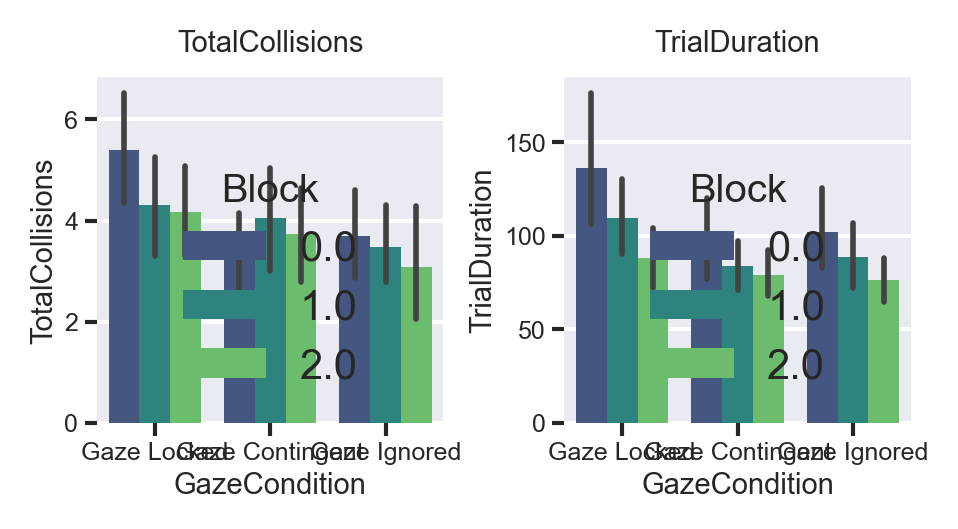

C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

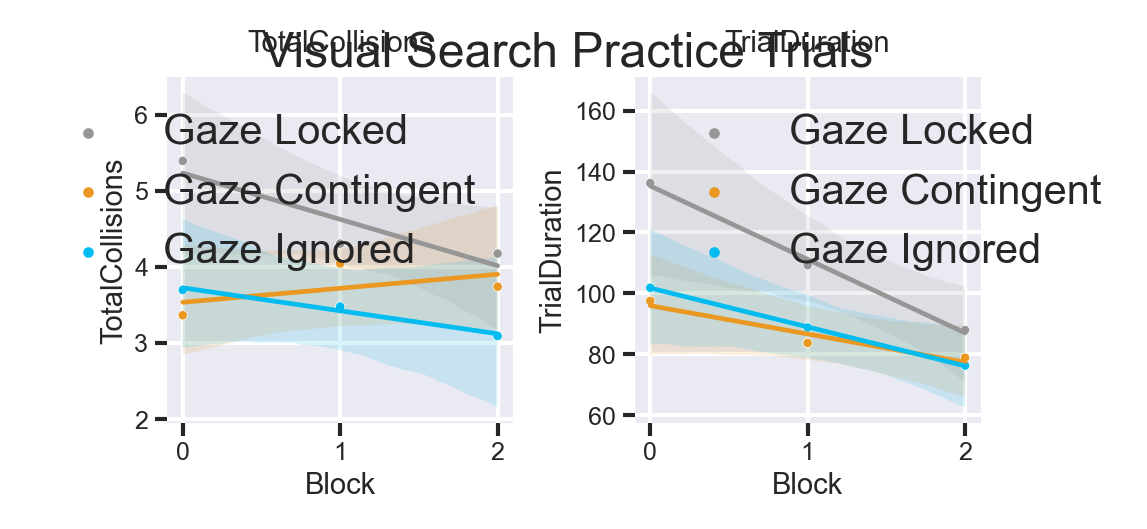

C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

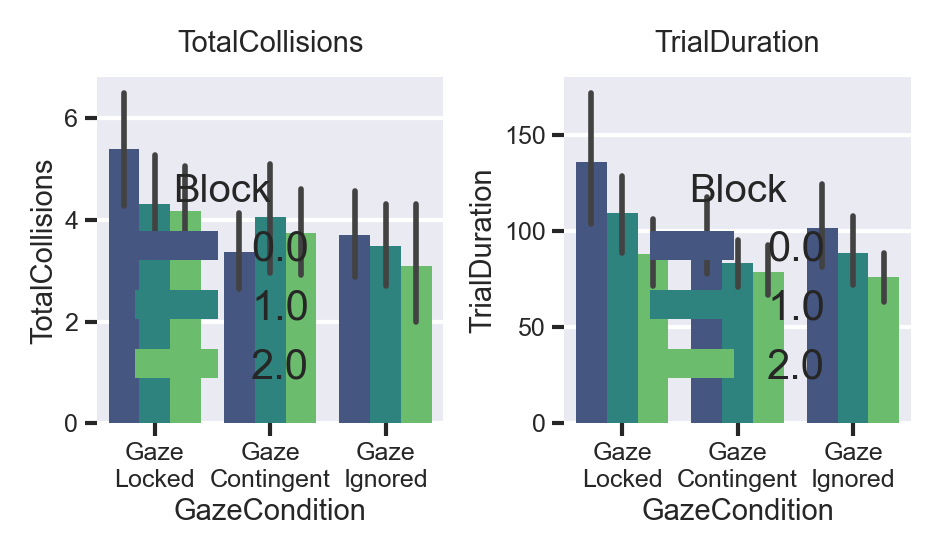

C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

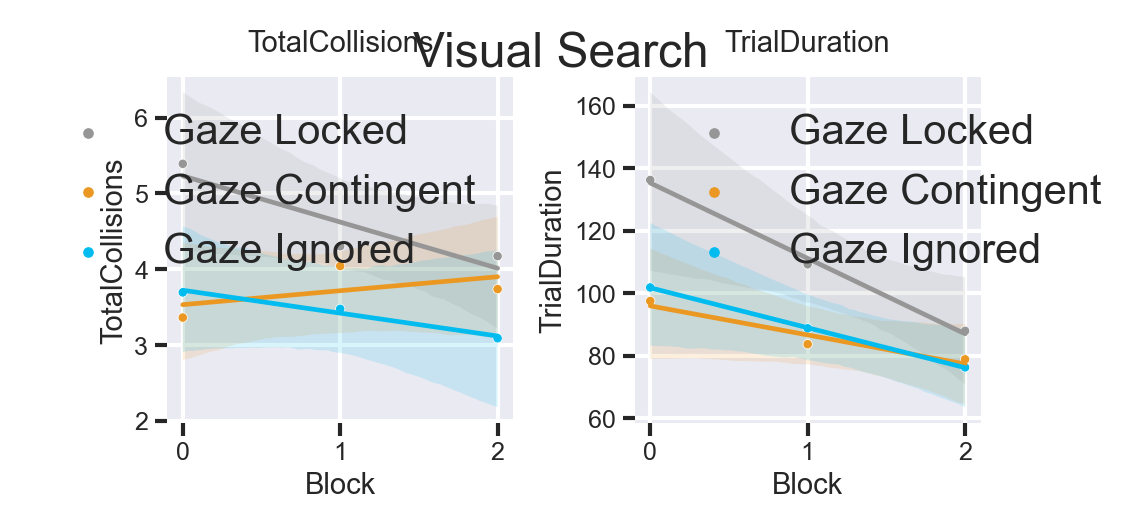

TotalCollisions (TotalCollisions ~ 1 + Block)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,4.169476,1.415351e-36,***
Block,-0.242647,2.430661e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,111.168085,3.087500e-50,***
Block,-15.480682,3.804959e-04,**


TotalCollisions (TotalCollisions ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:108: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,3.533835,6.641055e-13,***
GazeCondition[T.Gaze Ignored],0.189931,7.684349e-01,n.s.
GazeCondition[T.Gaze Locked],1.698049,9.029695e-03,*
Block,0.184047,6.030640e-01,n.s.
Block:GazeCondition[T.Gaze Ignored],-0.485780,3.322022e-01,n.s.
Block:GazeCondition[T.Gaze Locked],-0.792743,1.122726e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


C:\Users\Jaap\AppData\Local\Temp\ipykernel_12760\2843579492.py:108: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)


,Param,PValue,Significant?
Intercept,95.955182,1.117170e-19,***
GazeCondition[T.Gaze Ignored],5.792599,6.635316e-01,n.s.
GazeCondition[T.Gaze Locked],39.323994,3.462169e-03,*
Block,-9.290165,2.041897e-01,n.s.
Block:GazeCondition[T.Gaze Ignored],-3.486635,7.356716e-01,n.s.
Block:GazeCondition[T.Gaze Locked],-14.841430,1.494632e-01,n.s.


In [18]:
data= mb_results

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs)

formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results_all=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

plt.show()



fig, axs = visualization.regression_plots(data=data, endpoints=endpoints, scatter=False)
plt.suptitle(' Visual Search Practice Trials')


if len(endpoints)>1:

    for i,y in enumerate(endpoints):
        sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[[y]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs[i])
        visualization.redefine_legend_labels(axs[i])
else:
    sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=endpoints[0], 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs)
    visualization.redefine_legend_labels(axs)
    

plt.show()

data= mb_results

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs, new_line=True)


plt.show()

fig, axs = visualization.regression_plots(data=data, endpoints=endpoints, scatter=False)
plt.suptitle('Visual Search')

if len(endpoints)>1:

    for i,y in enumerate(endpoints):
        sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[[y]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs[i])
        visualization.redefine_legend_labels(axs[i])
else:
    sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=endpoints[0], 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs)
    visualization.redefine_legend_labels(axs)
    

plt.show()


# data = vs_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    

In [600]:
# vs_results = pd.read_csv('../visual_search/out/visual_search_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')
# vs_practice_results = pd.read_csv('../visual_search/out/practice_trials_visual_search_trial_endpoints.tsv', sep='\t')

practice_searches= pd.read_csv('../visual_search/out/practice_trials_all_searches.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])
practice_mask = pd.read_csv('../visual_search/out/practice_trials_inclusion_mask.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])

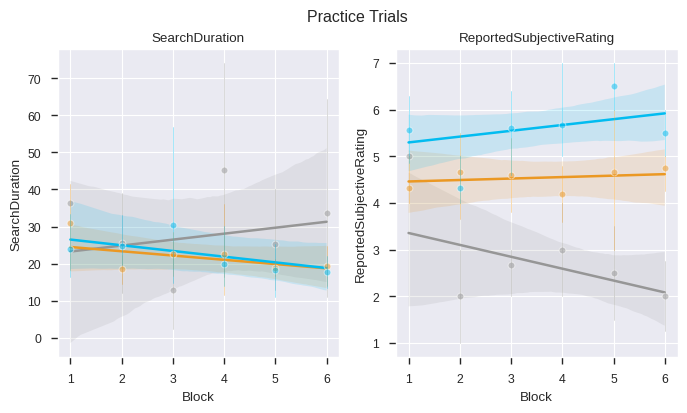

SearchDuration (SearchDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,25.340215,1.448993e-07,***
Block,-0.443698,6.882856e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.902816,1.968116e-17,***
Block,-0.122977,2.631541e-01,n.s.


SearchDuration (SearchDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,25.648135,0.000763,**
GazeCondition[T.GazeIgnored],2.387475,0.804184,n.s.
GazeCondition[T.SimulationFixedToGaze],-3.975902,0.762868,n.s.
Block,-1.149594,0.550996,n.s.
Block:GazeCondition[T.GazeIgnored],-0.386034,0.880680,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],2.753598,0.382789,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,4.431304,1.894817e-13,***
GazeCondition[T.GazeIgnored],0.743241,2.408075e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],-0.818097,3.444375e-01,n.s.
Block,0.031304,8.038482e-01,n.s.
Block:GazeCondition[T.GazeIgnored],0.093241,5.800567e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.286021,1.679961e-01,n.s.


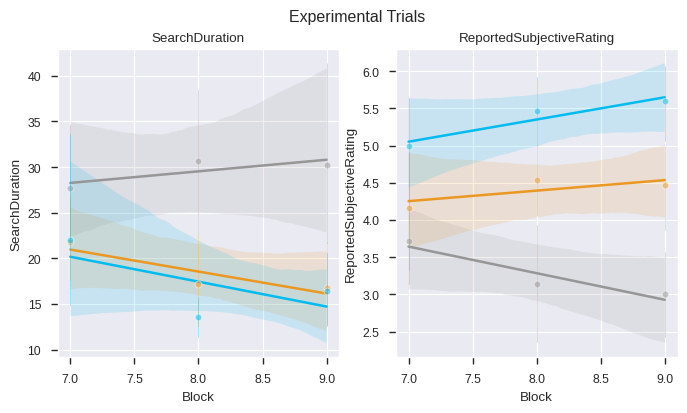

SearchDuration (SearchDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,33.149188,0.010520,*
Block,-1.424374,0.368044,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.004164,0.002320,**
Block,0.042960,0.788074,n.s.


SearchDuration (SearchDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,37.824257,0.078892,n.s.
GazeCondition[T.GazeIgnored],1.451952,0.960373,n.s.
GazeCondition[T.SimulationFixedToGaze],-18.440072,0.535324,n.s.
Block,-2.408607,0.360086,n.s.
Block:GazeCondition[T.GazeIgnored],-0.319825,0.929314,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],3.677759,0.317008,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,3.264000,0.080602,n.s.
GazeCondition[T.GazeIgnored],-0.300154,0.906966,n.s.
GazeCondition[T.SimulationFixedToGaze],2.878857,0.266771,n.s.
Block,0.141333,0.537187,n.s.
Block:GazeCondition[T.GazeIgnored],0.156941,0.621244,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.498476,0.121302,n.s.


In [663]:
# Practice Trials
endpoints = ['SearchDuration', 'ReportedSubjectiveRating']
indep_vars = ['Block']

data = practice_searches
data = data.loc[practice_mask.all(axis=1)]

# exclude_subjects = ['S37', 'S38', 'S39', 'S51']
exclude_blocks = [0,7,8,9]

data = data.loc[~data.Block.isin(exclude_blocks)]

data = data.groupby(['Subject','TrialIdentifier', 'GazeCondition'])[indep_vars+endpoints].mean().reset_index()

# data = data.loc[~data.Subject.isin(exclude_subjects)]

# data = exp_data['TrialConfigRecord']
# data = data.loc[(data.ExperimentalTask=='VisualSearch')].copy()
# data = data.loc[data.TrialIdentifier.str.contains(data_processing.PRACTICE_TRIALS)].copy()
# data = data.loc[~data.Subject.isin(exclude_subjects)]


fig, axs = visualization.create_subplots(2)
visualization.regression_plots(data=data, endpoints=endpoints, scatter=False, axs=axs)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data,#data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS, alpha=0.5,
                        ax=axs[i], linestyle='', marker='o',err_style='bars', err_kws={'elinewidth':0.5}, legend=False)
    axs[i].set(title=y)
plt.suptitle('Practice Trials')
plt.show()

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)


# Exp. Trials
data= vs_results.reset_index()
fig, axs = visualization.create_subplots(2)
visualization.regression_plots(data=data, endpoints=endpoints, scatter=False, axs=axs)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data,#data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS, alpha=0.5,
                        ax=axs[i], linestyle='', marker='o',err_style='bars', err_kws={'elinewidth':0.5}, legend=False)
    axs[i].set(title=y)
plt.suptitle('Experimental Trials')
plt.show()

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)




# axs[1].set(title='Exp. Trials')
# plt.suptitle('Visual Search Performance Over Time')

In [498]:
data.groupby(['Block', 'GazeCondition'])[endpoints[0]].std().reset_index()

,Block,GazeCondition,ReportedSubjectiveRating
0,7.0,GazeAssistedSampling,1.403459
1,7.0,GazeIgnored,1.358732
2,7.0,SimulationFixedToGaze,1.069045
3,8.0,GazeAssistedSampling,0.990430
4,8.0,GazeIgnored,0.877058
5,8.0,SimulationFixedToGaze,1.561909
6,9.0,GazeAssistedSampling,1.125463
7,9.0,GazeIgnored,1.055597
8,9.0,SimulationFixedToGaze,1.176697


<AxesSubplot: xlabel='Block', ylabel='ReportedSubjectiveRating'>

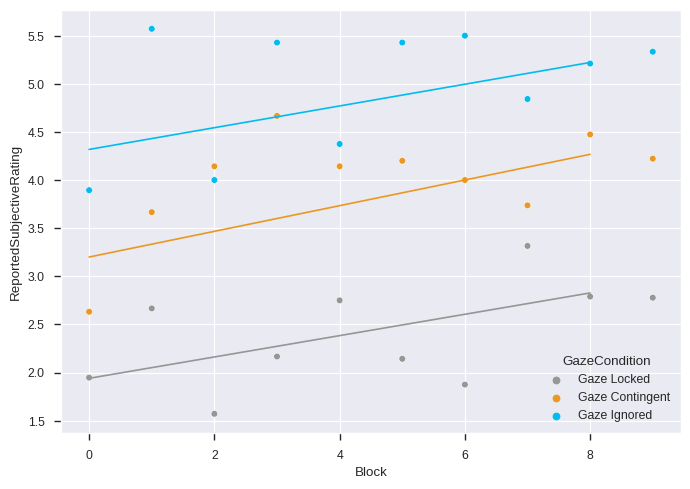

In [452]:
b0, b2a, b2b, b1, b3a, b3b  = results['ReportedSubjectiveRating'].Param

block = np.arange(9)
plt.plot(b0 + b1*block + b2b + block*b3b)
plt.plot(b0 + b1*block)
plt.plot(b0 + b1*block + b2a + block*b3a)

sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[['ReportedSubjectiveRating']].mean().reset_index(), 
                x='Block',
                y='ReportedSubjectiveRating', 
                hue='GazeCondition',
                hue_order = visualization.COND_REDEFINED.values()
               )

#### Scene recognition: first versus second session

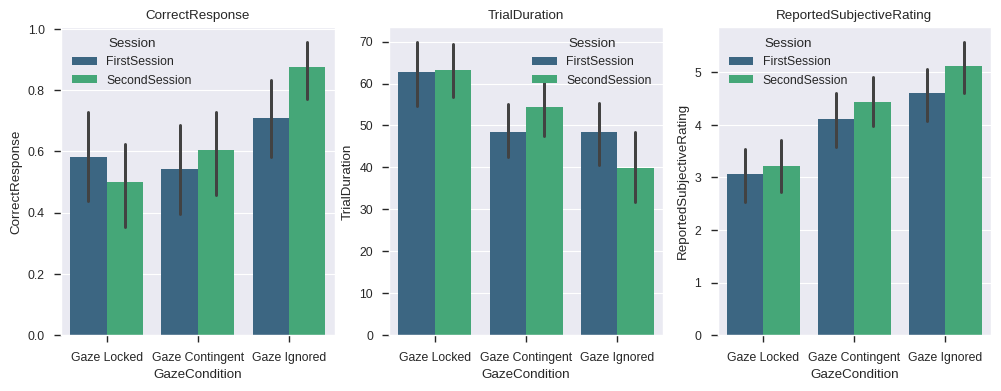

In [526]:
importlib.reload(visualization)

endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']   

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=sr_results, x='GazeCondition', endpoints=endpoints, hue='Session', palette='viridis')
visualization.redefine_x_ticks(axs)

plt.show()


# fig, axs = visualization.bar_plots(data = sr_results,
#                         endpoints=endpoints,
#                         x='Session',
#                         order=None,
#                         hue_order=visualization.ORDERED_CONDITIONS,
#                         hue='GazeCondition')
# visualization.redefine_legend_labels(axs)

data = sr_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})



In [527]:
formulas = {y: f'{y} ~ 1 + Session' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

CorrectResponse (CorrectResponse ~ 1 + Session)


,Param,PValue,Significant?
Intercept,0.611111,1.157924e-38,***
Session[T.SecondSession],0.048611,3.932133e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Session)


,Param,PValue,Significant?
Intercept,53.203439,2.290154e-68,***
Session[T.SecondSession],-0.721694,8.226329e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Session)


,Param,PValue,Significant?
Intercept,3.923611,7.045926e-73,***
Session[T.SecondSession],0.333333,1.390461e-01,n.s.


In [528]:
formulas = {y: f'{y} ~ 1 + Session + GazeCondition + Session:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

CorrectResponse (CorrectResponse ~ 1 + Session + GazeCondition + Session:GazeCondition)


,Param,PValue,Significant?
Intercept,0.541667,3.499631e-14,***
Session[T.SecondSession],0.062500,5.150622e-01,n.s.
GazeCondition[T.Gaze Ignored],0.166667,8.327969e-02,n.s.
GazeCondition[T.Gaze Locked],0.041667,6.642343e-01,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],0.104167,4.430399e-01,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-0.145833,2.831094e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Session + GazeCondition + Session:GazeCondition)


,Param,PValue,Significant?
Intercept,48.375195,6.151206e-30,***
Session[T.SecondSession],6.099673,2.541805e-01,n.s.
GazeCondition[T.Gaze Ignored],0.023379,9.965089e-01,n.s.
GazeCondition[T.Gaze Locked],14.461353,7.163927e-03,*
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],-14.740409,5.187613e-02,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-5.723692,4.490072e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Session + GazeCondition + Session:GazeCondition)


,Param,PValue,Significant?
Intercept,4.104167,1.785372e-41,***
Session[T.SecondSession],0.333333,3.587048e-01,n.s.
GazeCondition[T.Gaze Ignored],0.500000,1.689856e-01,n.s.
GazeCondition[T.Gaze Locked],-1.041667,4.375867e-03,*
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],0.187500,7.148898e-01,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-0.187500,7.148898e-01,n.s.


In [529]:
formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

CorrectResponse (CorrectResponse ~ 1 + Block)


,Param,PValue,Significant?
Intercept,0.604167,3.413151e-18,***
Block,0.008929,5.923462e-01,n.s.


TrialDuration (TrialDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,52.446470,2.308399e-35,***
Block,0.113178,9.044296e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,3.856944,5.219366e-38,***
Block,0.066667,3.127078e-01,n.s.


CorrectResponse (CorrectResponse ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,0.518229,0.000003,***
GazeCondition[T.Gaze Ignored],0.066805,0.674960,n.s.
GazeCondition[T.Gaze Locked],0.106200,0.482039,n.s.
Block,0.015625,0.572445,n.s.
Block:GazeCondition[T.Gaze Ignored],0.045599,0.278401,n.s.
Block:GazeCondition[T.Gaze Locked],-0.038456,0.310847,n.s.


TrialDuration (TrialDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,43.313031,3.369981e-12,***
GazeCondition[T.Gaze Ignored],17.156137,5.144976e-02,n.s.
GazeCondition[T.Gaze Locked],16.720053,4.528641e-02,n.s.
Block,2.317714,1.293984e-01,n.s.
Block:GazeCondition[T.Gaze Ignored],-7.174296,2.129689e-03,**
Block:GazeCondition[T.Gaze Locked],-1.492485,4.752474e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,4.112847,6.609276e-21,***
GazeCondition[T.Gaze Ignored],-0.440228,4.607122e-01,n.s.
GazeCondition[T.Gaze Locked],-0.821561,1.470040e-01,n.s.
Block,0.045139,6.632133e-01,n.s.
Block:GazeCondition[T.Gaze Ignored],0.308036,5.109694e-02,n.s.
Block:GazeCondition[T.Gaze Locked],-0.088137,5.348699e-01,n.s.


#### Scene recognition: effects of revisiting same environment

on average, 7.00 of the 9 environments in the second session were seen before


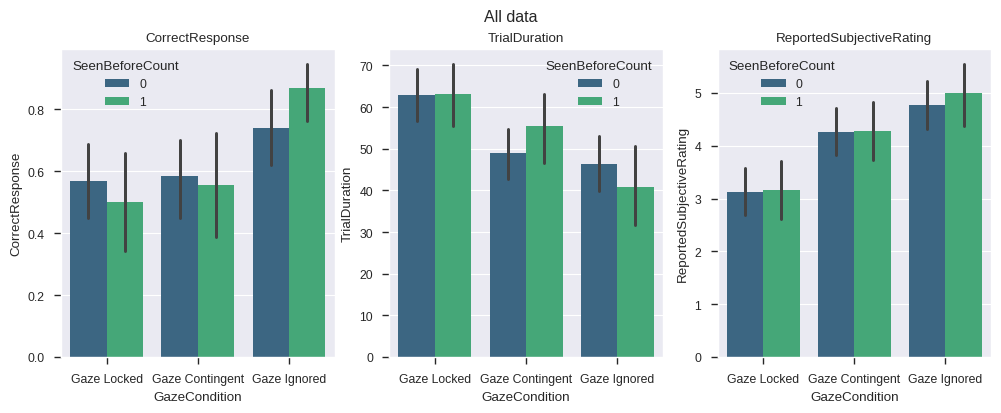

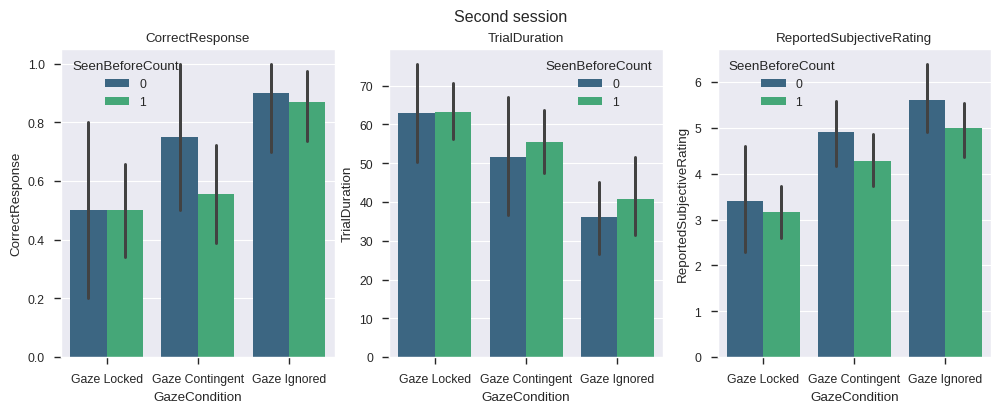

In [278]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

avg_seenbefore = sr_results.loc[sr_results.Session == 'SecondSession'].groupby(['Subject']).SeenBeforeCount.sum().mean()
print(f'on average, {avg_seenbefore:.2f} of the 9 environments in the second session were seen before')


fig, axs = visualization.bar_plots(data=sr_results, x='GazeCondition', endpoints=endpoints,
                                   hue='SeenBeforeCount', palette='viridis')
visualization.redefine_x_ticks(axs)
fig.suptitle('All data')

fig, axs = visualization.bar_plots(data=sr_results.loc[data.Session =='SecondSession'], x='GazeCondition',
                                   endpoints=endpoints, hue='SeenBeforeCount', palette='viridis')
visualization.redefine_x_ticks(axs)
fig.suptitle('Second session')
plt.show()

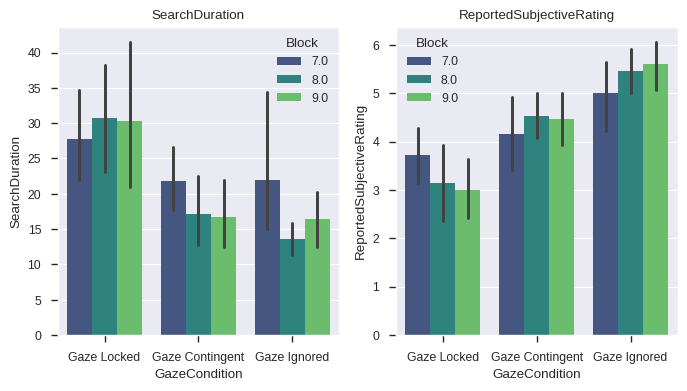

In [397]:
importlib.reload(visualization)

endpoints = ['SearchDuration', 'ReportedSubjectiveRating']
data = vs_results

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs)

plt.show()


# fig, axs = visualization.bar_plots(data = sr_results,
#                         endpoints=endpoints,
#                         x='Session',
#                         order=None,
#                         hue_order=visualization.ORDERED_CONDITIONS,
#                         hue='GazeCondition')
# visualization.redefine_legend_labels(axs)

data = vs_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})


#### Visual search block 1 vs 2 vs 3

In [398]:
formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

SearchDuration (SearchDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,33.149188,0.010520,*
Block,-1.424374,0.368044,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.004164,0.002320,**
Block,0.042960,0.788074,n.s.


In [399]:
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

SearchDuration (SearchDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,37.824257,0.078892,n.s.
GazeCondition[T.Gaze Ignored],1.451952,0.960373,n.s.
GazeCondition[T.Gaze Locked],-18.440072,0.535324,n.s.
Block,-2.408607,0.360086,n.s.
Block:GazeCondition[T.Gaze Ignored],-0.319825,0.929314,n.s.
Block:GazeCondition[T.Gaze Locked],3.677759,0.317008,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,3.264000,0.080602,n.s.
GazeCondition[T.Gaze Ignored],-0.300154,0.906966,n.s.
GazeCondition[T.Gaze Locked],2.878857,0.266771,n.s.
Block,0.141333,0.537187,n.s.
Block:GazeCondition[T.Gaze Ignored],0.156941,0.621244,n.s.
Block:GazeCondition[T.Gaze Locked],-0.498476,0.121302,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,3.019079,1.205896e-26,***
GazeCondition[T.GazeIgnored],1.158112,6.517098e-04,**
GazeCondition[T.SimulationFixedToGaze],-0.968975,3.978506e-03,*
Block,0.262500,4.918966e-04,**
Block:GazeCondition[T.GazeIgnored],-0.046220,6.653888e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.254149,1.429638e-02,*


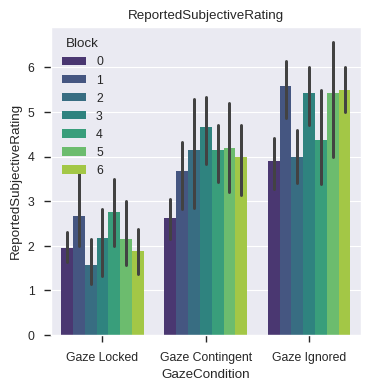

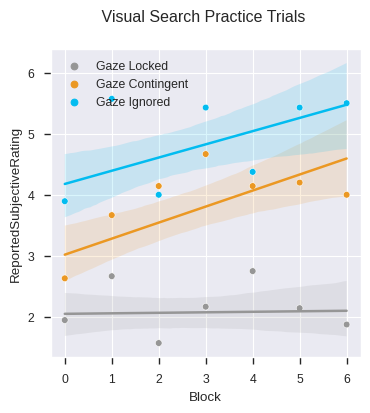

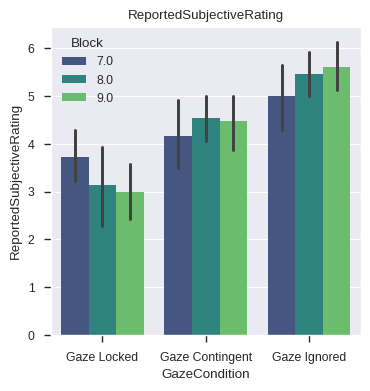

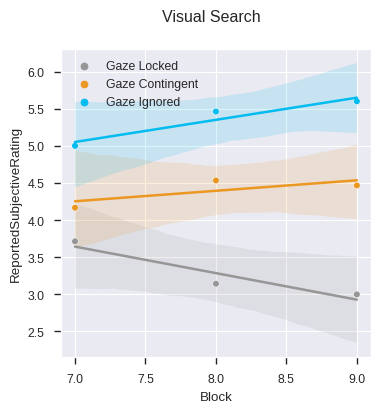

ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.004164,0.002320,**
Block,0.042960,0.788074,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,3.264000,0.080602,n.s.
GazeCondition[T.Gaze Ignored],-0.300154,0.906966,n.s.
GazeCondition[T.Gaze Locked],2.878857,0.266771,n.s.
Block,0.141333,0.537187,n.s.
Block:GazeCondition[T.Gaze Ignored],0.156941,0.621244,n.s.
Block:GazeCondition[T.Gaze Locked],-0.498476,0.121302,n.s.


In [480]:
endpoints = ['ReportedSubjectiveRating']
data = exp_data['TrialConfigRecord']
data = data.loc[(data.ExperimentalTask=='VisualSearch')].copy()

importlib.reload(visualization)

data = data.loc[data.TrialIdentifier.str.contains(data_processing.PRACTICE_TRIALS)].copy()

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs)

formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results_all=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

plt.show()



fig, axs = visualization.regression_plots(data=data, endpoints=endpoints, scatter=False)
plt.suptitle(' Visual Search Practice Trials')


if len(endpoints)>1:

    for i,y in enumerate(endpoints):
        sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[[y]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs[i])
        visualization.redefine_legend_labels(axs[i])
else:
    sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=endpoints[0], 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs)
    visualization.redefine_legend_labels(axs)
    

plt.show()

data= vs_results

visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs)


plt.show()

fig, axs = visualization.regression_plots(data=data, endpoints=endpoints, scatter=False)
plt.suptitle('Visual Search')

if len(endpoints)>1:

    for i,y in enumerate(endpoints):
        sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[[y]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs[i])
        visualization.redefine_legend_labels(axs[i])
else:
    sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=endpoints[0], 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS,
                        ax=axs)
    visualization.redefine_legend_labels(axs)
    

plt.show()


# data = vs_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
    
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    

In [600]:
# vs_results = pd.read_csv('../visual_search/out/visual_search_trial_endpoints.tsv', sep='\t').set_index('TrialIdentifier')
# vs_practice_results = pd.read_csv('../visual_search/out/practice_trials_visual_search_trial_endpoints.tsv', sep='\t')

practice_searches= pd.read_csv('../visual_search/out/practice_trials_all_searches.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])
practice_mask = pd.read_csv('../visual_search/out/practice_trials_inclusion_mask.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])

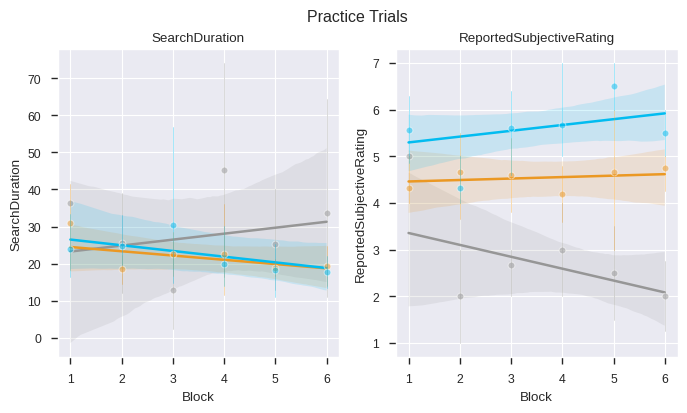

SearchDuration (SearchDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,25.340215,1.448993e-07,***
Block,-0.443698,6.882856e-01,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.902816,1.968116e-17,***
Block,-0.122977,2.631541e-01,n.s.


SearchDuration (SearchDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,25.648135,0.000763,**
GazeCondition[T.GazeIgnored],2.387475,0.804184,n.s.
GazeCondition[T.SimulationFixedToGaze],-3.975902,0.762868,n.s.
Block,-1.149594,0.550996,n.s.
Block:GazeCondition[T.GazeIgnored],-0.386034,0.880680,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],2.753598,0.382789,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,4.431304,1.894817e-13,***
GazeCondition[T.GazeIgnored],0.743241,2.408075e-01,n.s.
GazeCondition[T.SimulationFixedToGaze],-0.818097,3.444375e-01,n.s.
Block,0.031304,8.038482e-01,n.s.
Block:GazeCondition[T.GazeIgnored],0.093241,5.800567e-01,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.286021,1.679961e-01,n.s.


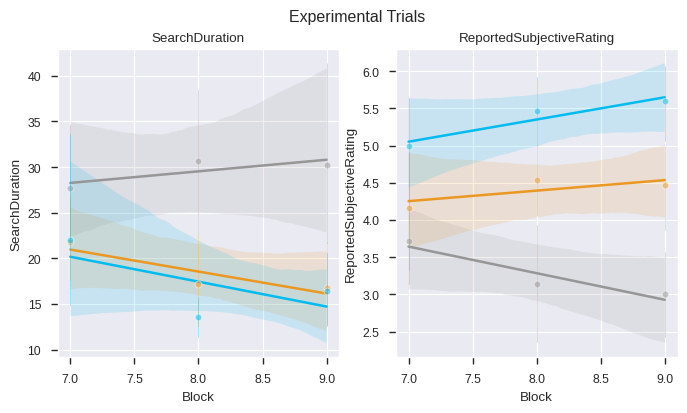

SearchDuration (SearchDuration ~ 1 + Block)


,Param,PValue,Significant?
Intercept,33.149188,0.010520,*
Block,-1.424374,0.368044,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block)


,Param,PValue,Significant?
Intercept,4.004164,0.002320,**
Block,0.042960,0.788074,n.s.


SearchDuration (SearchDuration ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,37.824257,0.078892,n.s.
GazeCondition[T.GazeIgnored],1.451952,0.960373,n.s.
GazeCondition[T.SimulationFixedToGaze],-18.440072,0.535324,n.s.
Block,-2.408607,0.360086,n.s.
Block:GazeCondition[T.GazeIgnored],-0.319825,0.929314,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],3.677759,0.317008,n.s.


ReportedSubjectiveRating (ReportedSubjectiveRating ~ 1 + Block + GazeCondition + Block:GazeCondition)


,Param,PValue,Significant?
Intercept,3.264000,0.080602,n.s.
GazeCondition[T.GazeIgnored],-0.300154,0.906966,n.s.
GazeCondition[T.SimulationFixedToGaze],2.878857,0.266771,n.s.
Block,0.141333,0.537187,n.s.
Block:GazeCondition[T.GazeIgnored],0.156941,0.621244,n.s.
Block:GazeCondition[T.SimulationFixedToGaze],-0.498476,0.121302,n.s.


In [663]:
# Practice Trials
endpoints = ['SearchDuration', 'ReportedSubjectiveRating']
indep_vars = ['Block']

data = practice_searches
data = data.loc[practice_mask.all(axis=1)]

# exclude_subjects = ['S37', 'S38', 'S39', 'S51']
exclude_blocks = [0,7,8,9]

data = data.loc[~data.Block.isin(exclude_blocks)]

data = data.groupby(['Subject','TrialIdentifier', 'GazeCondition'])[indep_vars+endpoints].mean().reset_index()

# data = data.loc[~data.Subject.isin(exclude_subjects)]

# data = exp_data['TrialConfigRecord']
# data = data.loc[(data.ExperimentalTask=='VisualSearch')].copy()
# data = data.loc[data.TrialIdentifier.str.contains(data_processing.PRACTICE_TRIALS)].copy()
# data = data.loc[~data.Subject.isin(exclude_subjects)]


fig, axs = visualization.create_subplots(2)
visualization.regression_plots(data=data, endpoints=endpoints, scatter=False, axs=axs)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data,#data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS, alpha=0.5,
                        ax=axs[i], linestyle='', marker='o',err_style='bars', err_kws={'elinewidth':0.5}, legend=False)
    axs[i].set(title=y)
plt.suptitle('Practice Trials')
plt.show()

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)


# Exp. Trials
data= vs_results.reset_index()
fig, axs = visualization.create_subplots(2)
visualization.regression_plots(data=data, endpoints=endpoints, scatter=False, axs=axs)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data,#data.groupby(['Block', 'GazeCondition'])[endpoints[0]].mean().reset_index(), 
                        x='Block',
                        y=y, 
                        hue='GazeCondition',
                        hue_order = visualization.ORDERED_CONDITIONS, alpha=0.5,
                        ax=axs[i], linestyle='', marker='o',err_style='bars', err_kws={'elinewidth':0.5}, legend=False)
    axs[i].set(title=y)
plt.suptitle('Experimental Trials')
plt.show()

formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)
    
formulas = {y: f'{y} ~ 1 + Block + GazeCondition + Block:GazeCondition' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)




# axs[1].set(title='Exp. Trials')
# plt.suptitle('Visual Search Performance Over Time')

In [498]:
data.groupby(['Block', 'GazeCondition'])[endpoints[0]].std().reset_index()

,Block,GazeCondition,ReportedSubjectiveRating
0,7.0,GazeAssistedSampling,1.403459
1,7.0,GazeIgnored,1.358732
2,7.0,SimulationFixedToGaze,1.069045
3,8.0,GazeAssistedSampling,0.990430
4,8.0,GazeIgnored,0.877058
5,8.0,SimulationFixedToGaze,1.561909
6,9.0,GazeAssistedSampling,1.125463
7,9.0,GazeIgnored,1.055597
8,9.0,SimulationFixedToGaze,1.176697


<AxesSubplot: xlabel='Block', ylabel='ReportedSubjectiveRating'>

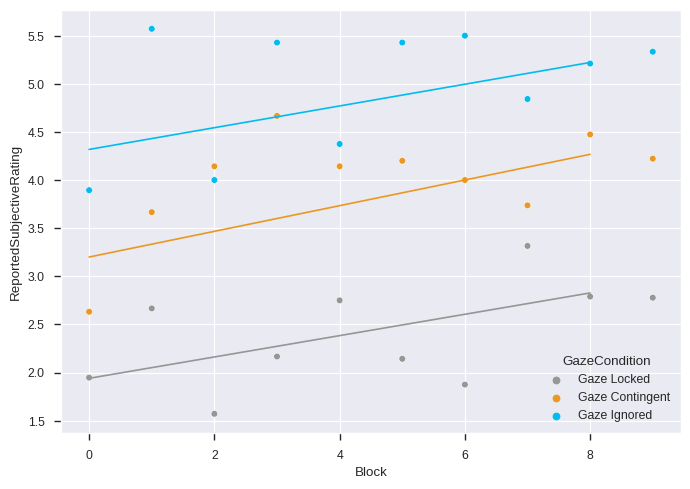

In [452]:
b0, b2a, b2b, b1, b3a, b3b  = results['ReportedSubjectiveRating'].Param

block = np.arange(9)
plt.plot(b0 + b1*block + b2b + block*b3b)
plt.plot(b0 + b1*block)
plt.plot(b0 + b1*block + b2a + block*b3a)

sns.scatterplot(data=data.groupby(['Block', 'GazeCondition'])[['ReportedSubjectiveRating']].mean().reset_index(), 
                x='Block',
                y='ReportedSubjectiveRating', 
                hue='GazeCondition',
                hue_order = visualization.COND_REDEFINED.values()
               )

#### Gaze analysis, effects of block

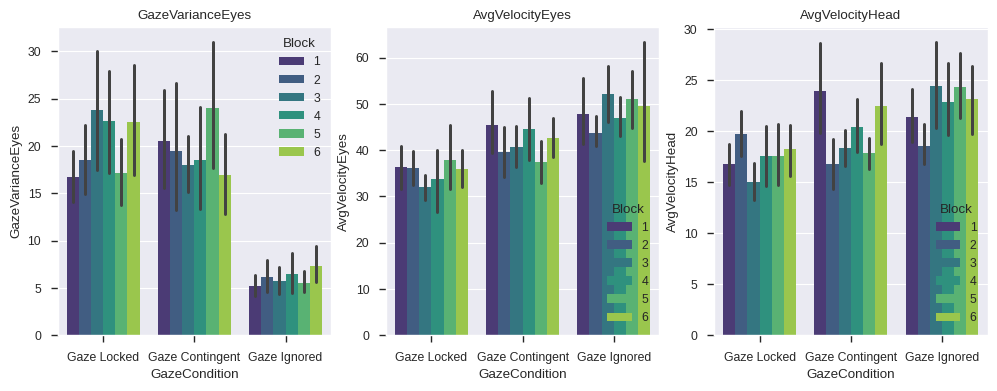

In [390]:
importlib.reload(visualization)

endpoints = ['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',]
data = ga_results.loc[ga_results.ExperimentalTask == 'VisualSearch'].copy()


visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data=ga_results.loc[ga_results.ExperimentalTask == 'SceneRecognition'], x='GazeCondition', endpoints=endpoints, hue='Block', palette='viridis')
visualization.redefine_x_ticks(axs)

plt.show()

In [388]:
# Without interactions
formulas = {y: f'{y} ~ 1 + Block' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key + f' ({formula})')
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['Significant?']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)


GazeVarianceEyes (GazeVarianceEyes ~ 1 + Block)


,Param,PValue,Significant?
Intercept,13.748413,4.974198e-19,***
Block,0.396442,2.884615e-01,n.s.


AvgVelocityEyes (AvgVelocityEyes ~ 1 + Block)


,Param,PValue,Significant?
Intercept,42.038153,1.918133e-76,***
Block,-0.002746,9.950650e-01,n.s.


AvgVelocityHead (AvgVelocityHead ~ 1 + Block)


,Param,PValue,Significant?
Intercept,19.340468,6.346035e-65,***
Block,0.204245,3.795948e-01,n.s.


In [387]:
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})

# With interaction
formulas = {y: f'{y} ~ Block + GazeCondition + Block:GazeCondition' for y in endpoints}
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key)
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['PValue']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

GazeVarianceEyes


,Param,PValue
Intercept,20.202546,***
GazeCondition[T.Gaze Ignored],-15.066489,***
GazeCondition[T.Gaze Locked],-2.437273,n.s.
Block,-0.243636,n.s.
Block:GazeCondition[T.Gaze Ignored],0.485438,n.s.
Block:GazeCondition[T.Gaze Locked],0.891544,n.s.


AvgVelocityEyes


,Param,PValue
Intercept,43.033778,***
GazeCondition[T.Gaze Ignored],3.356847,n.s.
GazeCondition[T.Gaze Locked],-8.143383,n.s.
Block,-0.331825,n.s.
Block:GazeCondition[T.Gaze Ignored],0.999906,n.s.
Block:GazeCondition[T.Gaze Locked],0.516072,n.s.


AvgVelocityHead


,Param,PValue
Intercept,19.752983,***
GazeCondition[T.Gaze Ignored],0.467886,n.s.
GazeCondition[T.Gaze Locked],-2.511072,n.s.
Block,0.066416,n.s.
Block:GazeCondition[T.Gaze Ignored],0.639783,n.s.
Block:GazeCondition[T.Gaze Locked],0.022456,n.s.


## Regression analysis

CorrectResponse


,Param,PValue
Intercept,0.541667,***
Session[T.SecondSession],0.062500,n.s.
GazeCondition[T.Gaze Ignored],0.166667,n.s.
GazeCondition[T.Gaze Locked],0.041667,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],0.104167,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-0.145833,n.s.


TrialDuration


,Param,PValue
Intercept,48.375195,***
Session[T.SecondSession],6.099673,n.s.
GazeCondition[T.Gaze Ignored],0.023379,n.s.
GazeCondition[T.Gaze Locked],14.461353,*
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],-14.740409,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-5.723692,n.s.


ReportedSubjectiveRating


,Param,PValue
Intercept,4.104167,***
Session[T.SecondSession],0.333333,n.s.
GazeCondition[T.Gaze Ignored],0.500000,n.s.
GazeCondition[T.Gaze Locked],-1.041667,*
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],0.187500,n.s.
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-0.187500,n.s.


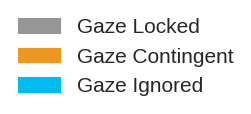

In [340]:
import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)

visualization.set_figurestyle()
visualization.plot_legend(size=15, figsize=(1,1))

## Scene recognition data
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']


data = sr_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})

formulas = {y: f'{y} ~ Session + GazeCondition + Session:GazeCondition' for y in endpoints}

results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})
    print(key)
    out = result.rename(columns = {0: 'Param', 1:'PValue'})
    out[['PValue']]= out[['PValue']].applymap(stats.count_significance_stars)
    display(out)

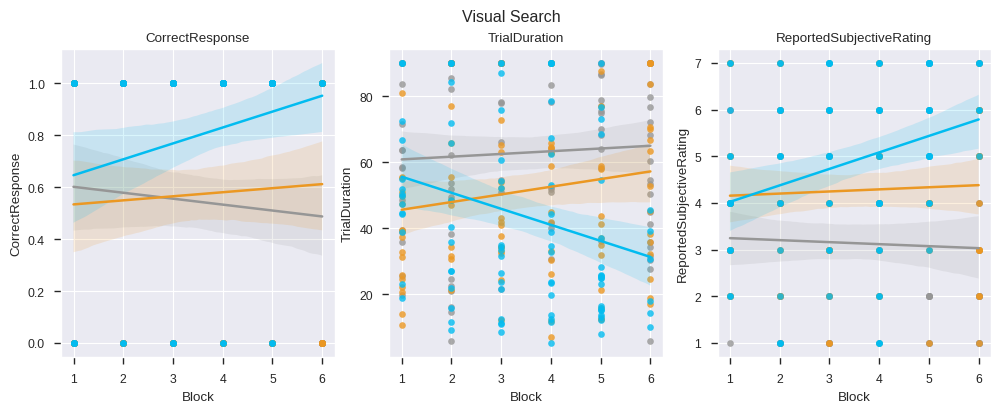

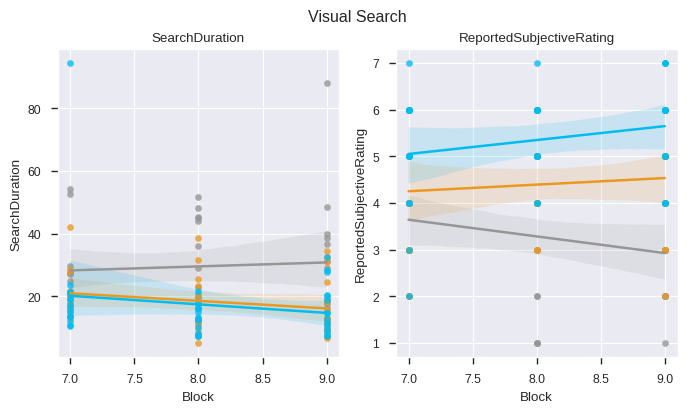

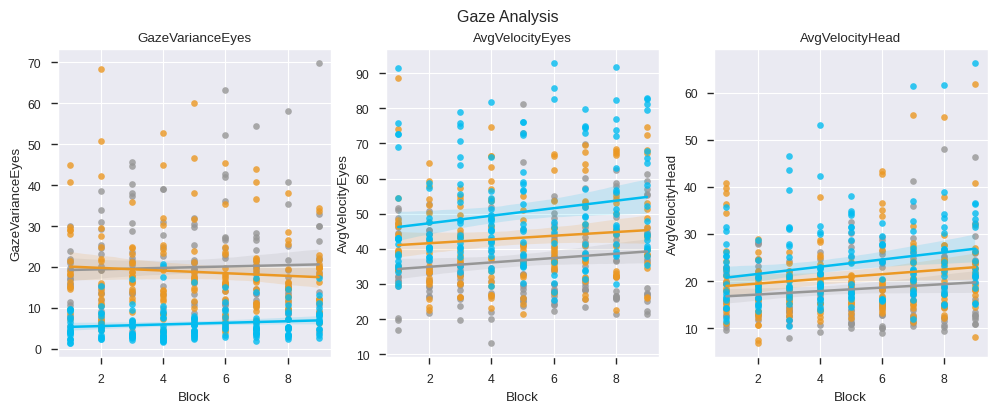

In [405]:
## Scene recognition data
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
visualization.regression_plots(data=sr_results, endpoints=endpoints)
plt.suptitle('Visual Search')

## Visual search data
endpoints = ['SearchDuration', 'ReportedSubjectiveRating']
visualization.regression_plots(data=vs_results, endpoints=endpoints)
plt.suptitle('Visual Search')

# Gaze analysis
endpoints=['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',]
fig, axs = visualization.regression_plots(data=ga_results, endpoints=endpoints)
plt.suptitle('Gaze Analysis')

plt.show()

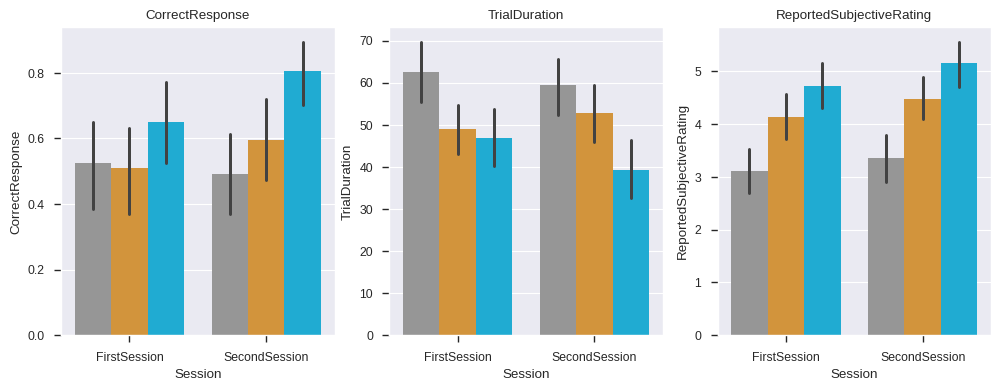

In [259]:
endpoints= ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

sr_results['Session'] = (sr_results.Block > 3).replace({False: 'FirstSession', True: 'SecondSession'})

sr_results['Session'] = (sr_results.Block > 3).replace({False: 'FirstSession', True: 'SecondSession'})
sr_results['SessionNumber'] = (sr_results.Block > 3).replace({False: 1, True: 2})

data = sr_results.groupby(['Subject','Block','Session', 'SessionNumber', 'GazeCondition'])[endpoints].mean().reset_index


fig, axs = visualization.bar_plots(data = sr_results,
                        endpoints=endpoints,
                        x='Session',
                        order=None,
                        hue_order=visualization.ORDERED_CONDITIONS,
                        hue='GazeCondition')

for ax in axs:
    ax.legend_.remove()

#### Interaction effects?

In [244]:
import statsmodels
import statsmodels.api as sm 
import statsmodels.formula.api as smf

data = sr_results.copy()
data = data.replace({'GazeCondition':visualization.COND_REDEFINED})

# # Only gaze-locked versus gaze contingent data
# data = data.loc[data.GazeCondition.isin(['GazeAssistedSampling', 'SimulationFixedToGaze'])].copy()
# data['GazeContingent'] = (data.GazeCondition == 'GazeAssistedSampling').astype(float)
# data = data.reset_index()

formulas = {'CorrectResponse': 'CorrectResponse ~ Session + GazeCondition + Session:GazeCondition',
            'TrialDuration': 'TrialDuration ~ Session + GazeCondition + Session:GazeCondition',
            'ReportedSubjectiveRating': 'ReportedSubjectiveRating ~ Session + GazeCondition + Session:GazeCondition'}
            
results=dict()
for key,formula in formulas.items():
    fit = smf.ols(data=data, formula=formula).fit()
    result = pd.concat([fit.params, fit.pvalues],axis=1)
    results[key] = result.rename(columns = {0: 'Param', 1:'PValue'})

In [245]:
results['CorrectResponse'].style.applymap(stats.highlight_significant, alpha=0.05)

,Param,PValue
Intercept,0.508772,0.000000
Session[T.SecondSession],0.087719,0.332646
GazeCondition[T.Gaze Ignored],0.140351,0.121528
GazeCondition[T.Gaze Locked],0.017544,0.846262
Session[T.SecondSession]:GazeCondition[T.Gaze Ignored],0.070175,0.583489
Session[T.SecondSession]:GazeCondition[T.Gaze Locked],-0.122807,0.337521


In [252]:
endpoints=['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
data.groupby(['Subject','Block','GazeCondition'])[endpoints].mean()

CorrectResponse  TrialDuration  \
Subject Block GazeCondition                                     
S35     1     Gaze Contingent         1.000000      47.464963   
        2     Gaze Ignored            0.666667      79.974447   
        3     Gaze Locked             0.333333      85.969403   
        4     Gaze Ignored            1.000000      67.885823   
        5     Gaze Locked             1.000000      64.072837   
...                                        ...            ...   
S57     2     Gaze Locked             0.666667      36.792647   
        3     Gaze Contingent         0.666667      33.512123   
        4     Gaze Locked             0.000000      37.392903   
        5     Gaze Ignored            1.000000      21.617677   
        6     Gaze Contingent         1.000000      29.771320   

                               ReportedSubjectiveRating  
Subject Block GazeCondition                              
S35     1     Gaze Contingent                  2.333333  
        2     Gaze Ignored                     1.333333  
        3     Gaze Locked                      1.333333  
        4     Gaze Ignored                     1.666667  
        5     Gaze Locked                      1.333333  
...                                                 ...  
S57     2     Gaze Locked                      4.000000  
        3     Gaze Contingent                  4.000000  
        4     Gaze Locked                      3.666667  
        5     Gaze Ignored                     4.666667  
        6     Gaze Contingent                  5.666667  

[114 rows x 3 columns]

In [191]:

# Only gaze-locked versus gaze contingent data
data = sr_results.loc[sr_results.GazeCondition.isin(['GazeAssistedSampling', 'SimulationFixedToGaze'])].copy()
data['GazeContingent'] = (data.GazeCondition == 'GazeAssistedSampling').astype(float)
data = data.reset_index()

# Without interaction
X = data[['Block', 'GazeContingent']]
y = data['TrialDuration']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrialDuration   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.706
Date:                Tue, 22 Aug 2023   Prob (F-statistic):            0.00994
Time:                        15:27:20   Log-Likelihood:                -1060.7
No. Observations:                 228   AIC:                             2127.
Df Residuals:                     225   BIC:                             2138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             58.7832      4.226     13.911      0.000      50.456      67.110
Block              0.6218      0.966      0.643      0.521      -1.283       2.526
GazeContingent   -10.0780      3.383     -2.979      0.003     -16.744      -3.412
==============================================================================
Omnibus:                       63.838   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.812
Skew:                          -0.103   Prob(JB):                      0.00272
Kurtosis:                       1.904   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special
poly = PolynomialFeatures(interaction_only=True)
poly_transform = poly.fit_transform(X)
interactions = pd.DataFrame(poly_transform,columns=poly.get_feature_names_out())
interactions = interactions.drop(columns=['1', 'Block', 'GazeContingent'])
Xt = pd.concat([X,interactions],axis=1)

model = linear_model.OLS(y, sm.add_constant(Xt)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrialDuration   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.400
Date:                Tue, 22 Aug 2023   Prob (F-statistic):             0.0186
Time:                        15:27:24   Log-Likelihood:                -1060.3
No. Observations:                 228   AIC:                             2129.
Df Residuals:                     224   BIC:                             2142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   61.7670      5.391     11.457      0.000      51.143      72.391
Block                   -0.2058      1.340     -0.154      0.878      -2.847       2.435
GazeContingent         -16.2073      7.660     -2.116      0.035     -31.302      -1.113
Block GazeContingent     1.7264      1.935      0.892      0.373      -2.088       5.540
==============================================================================
Omnibus:                       60.864   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.726
Skew:                          -0.117   Prob(JB):                      0.00284
Kurtosis:                       1.914   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [203]:
model = smf.ols(data=data, formula= "TrialDuration ~ Block + GazeContingent + Block:GazeContingent").fit()
model = smf.ols(data=data, formula= "TrialDuration ~ Block + GazeCondition").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrialDuration   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.706
Date:                Tue, 22 Aug 2023   Prob (F-statistic):            0.00994
Time:                        15:34:26   Log-Likelihood:                -1060.7
No. Observations:                 228   AIC:                             2127.
Df Residuals:                     225   BIC:                             2138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 48.7052      4.142     11.758      0.000      40.543      56.868
GazeCondition[T.SimulationFixedToGaze]    10.0780      3.383      2.979      0.003       3.412      16.744
Block                                      0.6218      0.966      0.643      0.521      -1.283       2.526
==============================================================================
Omnibus:                       63.838   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.812
Skew:                          -0.103   Prob(JB):                      0.00272
Kurtosis:                       1.904   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [198]:
dir(model.pvalues)

['Block',
 'GazeContingent',
 'Intercept',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__rad

In [199]:
model.pvalues

Intercept         3.712242e-32
Block             5.206323e-01
GazeContingent    3.207692e-03
dtype: float64